2D+T dynamic MRI simulation using GA radial sampling
reconstructed with temporal "TV" regularizer (corner-rounded)  
2019-06-13, Jeff Fessler  
2019-06-23 update to use more realistic simulated sensitivity maps

In [1]:
using MIRT
using Plots: gui, plot, scatter
using LinearAlgebra: norm, Diagonal
using Random: seed!
using LinearMaps
jim(:abswarn, false); # suppress warnings about display of |complex| images

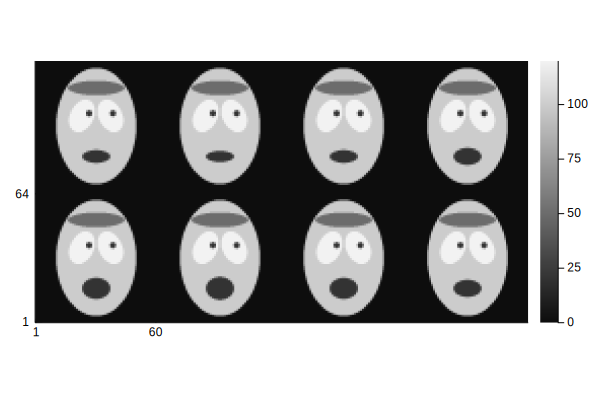

In [2]:
# generate dynamic image sequence
if !@isdefined(xtrue)
	N = (60,64)
	fov = 220
	nt = 8 # frames
	ig = image_geom(nx=N[1], ny=N[2], fov=fov)

	_,ellpar = ellipse_im(ig, :southpark, return_params=true)
	ellpars = Array{Float32}(undef, size(ellpar)..., nt)
	xtrue = Array{ComplexF32}(undef, N..., nt)
	for it=1:nt
		tmp = ellpar
		tmp[2,4] = 15 + 5 * sin(2*pi*it/nt) # mouth open/close
		ellpars[:,:,it] = tmp
		xtrue[:,:,it] = ellipse_im(ig, ellpars[:,:,it], oversample=4)
		jim(ig.x, ig.y, xtrue[:,:,it], title="frame $it")
		gui()
	end
end
jim(xtrue, yflip=ig.dy < 0)

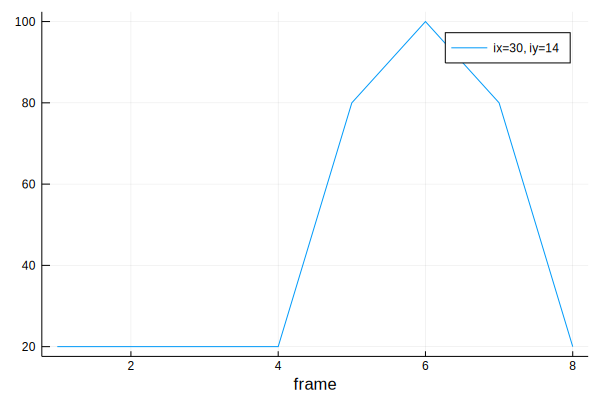

In [3]:
# plot one time course to see temporal change
ix,iy = 30,14
plot(1:nt, abs.(xtrue[ix,iy,:]), label="ix=$ix, iy=$iy", xlabel="frame")

In [4]:
# k-space sampling and data
if !@isdefined(kspace)
	@show accelerate = 3
	@show nspf = round(Int, maximum(N)/accelerate) # spokes per frame
	Nro = maximum(N)
	Nspoke = nspf * nt
	kspace = ir_mri_kspace_ga_radial(Nro = Nro, Nspoke = Nspoke)
	kspace[:,:,1] ./= ig.fovs[1]
    kspace[:,:,2] ./= ig.fovs[2]
	kspace = reshape(kspace, Nro, nspf, nt, 2)
end

if true # plot sampling
	ps = Array{Any}(undef, nt)
	for it=1:nt
		ps[it] = scatter(kspace[:,:,it,1], kspace[:,:,it,2], aspect_ratio=1, label="")
		plot(ps[it])
		gui()
	end
	plot(ps..., layout=(2,4))
end

accelerate = 3 = 3
nspf = round(Int, maximum(N) / accelerate) = 21


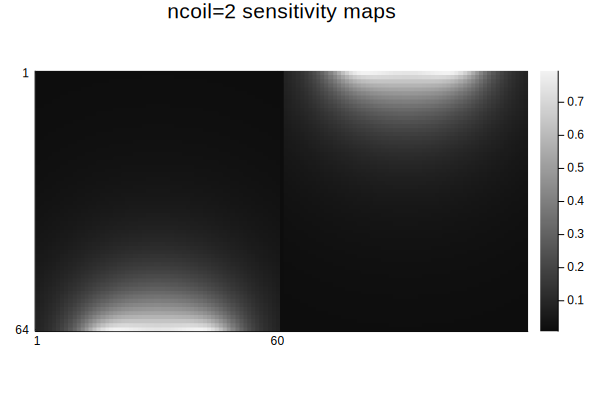

In [5]:
# make sensitivity maps
ncoil = 2
(smap,_) = ir_mri_sensemap_sim(dims=N, ncoil=ncoil, orbit_start=90)
jim(smap, "ncoil=$ncoil sensitivity maps")

In [6]:
# make system matrix for dynamic non-Cartesian parallel MRI
if !@isdefined(A)
	# a NUFFT object for each frame
	ns = Array{Any}(undef, nt)
	for it=1:nt
		om = [kspace[:,:,it,1][:] kspace[:,:,it,2][:]] * fov * 2 * pi
		ns[it] = nufft_init(om, N, n_shift = collect(N)/2)
	end

	# block diagonal system matrix, with one NUFFT per frame
	# todo: more realistic coil sensitivity
	ncoil = size(smap,3)
#   S = [Diagonal(ic*ones(Float32, N)[:]) for ic=1:ncoil] # silly sensitivity maps
    S = [Diagonal(ic*ones(Float32, N)[:]) for ic=1:ncoil] # simulated sensitivity maps
	Slm = block_lm(S, how=:col) # [S1; ... ; Sncoil]
	mykron = A1 -> block_lm([A1], how=:kron, Mkron=ncoil) # one NUFFT per coil

	# output is essentially [nt Ncoil nspf Nro] (which is possibly unusual)
	# input is [N... nt]
	A = block_lm([mykron(s.A)*Slm for s in ns], how=:diag);
end
size(A)

(21504, 30720)

In [7]:
# simulate k-space data via an inverse crime
if !@isdefined(y)
	ytrue = A * xtrue[:]

	snr2sigma = (db, yb) -> # compute noise sigma from SNR (no sqrt(2) needed)
		10^(-db/20) * norm(yb) / sqrt(length(yb))

	sig = Float32(snr2sigma(50, ytrue))
	seed!(0)
	y = ytrue + sig * randn(ComplexF32, size(ytrue))
	@show 20*log10(norm(ytrue) / norm(y - ytrue)) # verify SNR
end

20 * log10(norm(ytrue) / norm(y - ytrue)) = 50.018814f0


50.018814f0

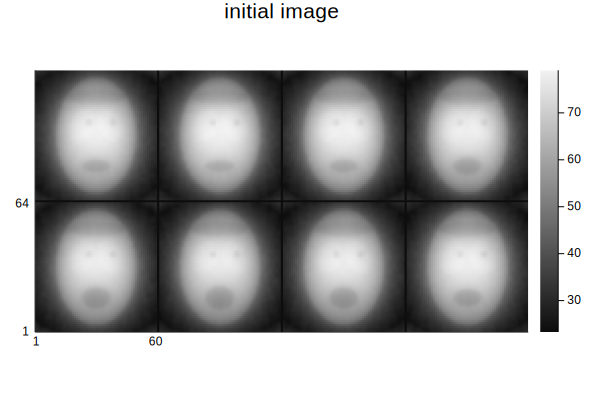

In [8]:
# initial image via zero-fill and scaling
if !@isdefined(x0)
	# todo: should use density compensation, perhaps via
	# https://github.com/JuliaGeometry/VoronoiDelaunay.jl
	x0 = reshape(A' * y, N..., nt) # zero-filled recon

	tmp = A * x0[:]
	x0 = (tmp'y / norm(tmp)^2) * x0 # scale sensibly
end
jim(x0, "initial image", yflip=ig.dy < 0)

In [9]:
"""
`make_Dt(N3i::Dims; T::DataType=Float32)`
temporal finite difference object
"""
function make_Dt(N3i::Dims; T::DataType=Float32)
	diff3_adj = y -> cat(dims=3,
		-(@views y[:,:,1]),
		(@views y[:,:,1:(end-1)] - y[:,:,2:end]),
		(@views y[:,:,end]))

	N3o = N3i .- (0,0,1) # (nx ny nt-1)
	return LinearMap{T}(
			x -> diff(reshape(x, N3i), dims=3)[:],
			y -> diff3_adj(reshape(y, N3o))[:],
			prod(N3o), prod(N3i))
end

make_Dt

In [10]:
if false # test
function make_Dt(test::Symbol)
	D = make_Dt((3,4,5))
#	tmp = Matrix(D)
#	jim(tmp'), gui()
#	tmp = Matrix(D')
#	jim(tmp'), gui()
#	@show maximum(abs.(Matrix(D)))
#	@show maximum(abs.(Matrix(D')))
#	@show maximum(abs.(Matrix(D)' - Matrix(D')))

#	@test Matrix(D)' == Matrix(D')
	true
end
end

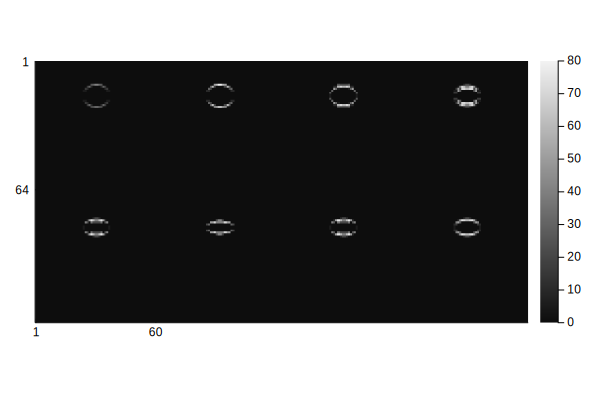

In [11]:
# temporal finite differences
if !@isdefined(Dt)
	N3i = (N..., nt) # (nx ny nt)
    N3o = (N..., nt-1) # (nx ny nt-1)
    Dt = make_Dt(N3i, T=eltype(A))
end

	tmp = reshape(Dt * xtrue[:], N3o)
#	jim(tmp), gui()
	tmp = reshape(Dt' * tmp[:], N3i)
	jim(tmp)

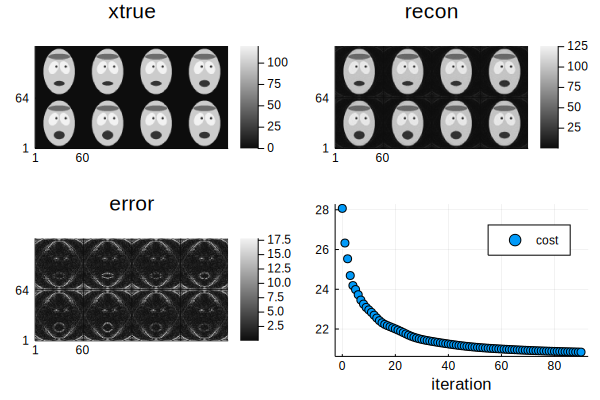

In [12]:
# run nonlinear CG
if !@isdefined(xh)
	niter = 90
	delta = Float32(0.1) # small relative to temporal differences
	reg = Float32(2^20) # trial and error here
	ffair = (t,d) -> d^2 * (abs(t)/d - log(1 + abs(t)/d))
	pot = z -> ffair(z, delta)
	dpot = z -> z / (Float32(1) + abs(z/delta))
	cost = x -> 0.5 * norm(A*x - y)^2 + reg * sum(pot.(Dt * x))
	fun = (x,iter) -> cost(x)
	gradf = [v -> v - y, u -> reg * dpot.(u)]
	curvf = [v -> Float32(1), u -> reg]
	B = [A,Dt]
	(xh, out) = ncg(B, gradf, curvf, x0[:]; niter=niter, fun=fun)
	xh = reshape(xh, N3i)
	costs = [out[i+1][1] for i=0:niter]
end

# show results
	plot(layout=(2,2),
		jim(xtrue, "xtrue", yflip=ig.dy < 0),
		jim(xh, "recon", yflip=ig.dy < 0),
		jim(xh-xtrue, "error", yflip=ig.dy < 0),
		scatter(0:niter, log.(costs), label="cost", xlabel="iteration"),
	)